In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
%matplotlib inline

In [2]:
df = pd.read_csv('~/Downloads/amazon_reviews_us_Watches_v1_00.tsv', 
                 delimiter='\t',
                 error_bad_lines=False)

b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\nSkipping line 197011: expected 15 fields, saw 22\nSkipping line 197432: expected 15 fields, saw 22\nSkipping line 208016: expected 15 fields, saw 22\nSkipping line 214110: expected 15 fields, saw 22\nSkipping line 244328: expected 15 fields, saw 22\nSkipping line 248519: expected 15 fields,

In [3]:
# sample top of the dataset
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31


In [4]:
df.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,9.602040e+05,9.602040e+05,960204.000000,960204.000000,960204.000000
mean,2.600101e+07,5.060448e+08,4.138161,1.197180,1.561571
std,1.581616e+07,2.864151e+08,1.293327,8.163426,9.071388
min,1.001600e+04,4.384000e+03,1.000000,0.000000,0.000000
25%,1.280548e+07,2.588358e+08,4.000000,0.000000,0.000000
50%,2.396748e+07,5.166657e+08,5.000000,0.000000,0.000000
75%,4.108624e+07,7.491827e+08,5.000000,1.000000,1.000000
max,5.309646e+07,9.999979e+08,5.000000,4004.000000,4249.000000


In [5]:
print('Unique Customers: {}'.format(len(df.customer_id.unique())))
print('Unique Products: {}'.format(len(df.product_id.unique())))

Unique Customers: 719522
Unique Products: 149658


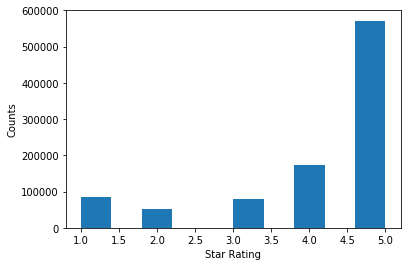

In [6]:
# distribution of stars ratings in reviews
plt.hist(df.star_rating)
plt.xlabel('Star Rating')
plt.ylabel('Counts')
plt.show()

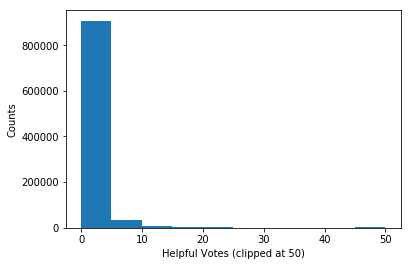

In [7]:
# distribution of helpful votes in reviews
plt.hist(np.clip(df.helpful_votes, 0, 50))
plt.xlabel('Helpful Votes (clipped at 50)')
plt.ylabel('Counts')
plt.show()

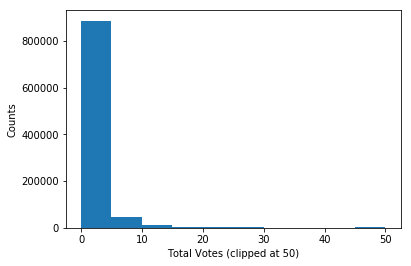

In [8]:
# distribution of total votes in reviews
plt.hist(np.clip(df.total_votes, 0, 50))
plt.xlabel('Total Votes (clipped at 50)')
plt.ylabel('Counts')
plt.show()

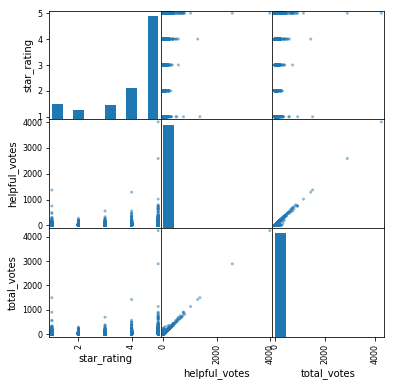

In [9]:
# this cell will take some time to run (plotting all values in correlation matrix)
pd.plotting.scatter_matrix(df[['star_rating', 'helpful_votes', 'total_votes']], figsize=(6, 6))
plt.show()

In [10]:
# top star_rating with no filter
df.groupby('product_id').agg(['mean', 'count']).sort_values([('star_rating', 'mean')], ascending=False).head(10)

customer_id       product_parent       star_rating        \
                  mean count           mean count        mean count   
product_id                                                            
1380137136  51483206.0     1    518987366.0     1         5.0     1   
B007K1PCIW  16660137.0     1    978864006.0     1         5.0     1   
B007K7EF5W   8478905.0     1    874242421.0     1         5.0     1   
B007K5B71Y  35689437.5     2    241411351.0     2         5.0     2   
B007K5B6Z6  33458367.0     1    621913171.0     1         5.0     1   
B007K5B3WM  45187237.0     1    786395679.0     1         5.0     1   
B007K5B3VS  17952767.0     1    874974768.0     1         5.0     1   
B007K44OWE   6537352.0     1     80314280.0     1         5.0     1   
B007K447YY  31932434.0     1    503003533.0     1         5.0     1   
B007JYU424  37287899.0     2    703415811.0     2         5.0     2   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
1380137136           0.0     1         0.0     1  
B007K1PCIW           0.0     1         0.0     1  
B007K7EF5W           0.0     1         0.0     1  
B007K5B71Y           0.0     2         0.0     2  
B007K5B6Z6           0.0     1         0.0     1  
B007K5B3WM           0.0     1         0.0     1  
B007K5B3VS           0.0     1         0.0     1  
B007K44OWE           0.0     1         0.0     1  
B007K447YY           0.0     1         0.0     1  
B007JYU424           0.0     2         0.0     2

In [11]:
# Review date range
min_review_date = pd.to_datetime(df.review_date).min()
max_review_date = pd.to_datetime(df.review_date).max()
"Reviews are from {} to {}".format(min_review_date, max_review_date)

'Reviews are from 2001-04-05 00:00:00 to 2015-08-31 00:00:00'

In [12]:
# Top Tier: Products that appear at the very top of rankings
top_tier_search_sources = [
    'fashion-mens-watches-pg1.html',
    'fashion-mens-watches-pg2.html',
    'fashion-mens-watches-pg3.html',
]

# High Tier: Products that appear between Top Tier and Mid Tier of rankings
high_tier_search_sources = [
    'fashion-mens-watches-pg100.html',
    'fashion-mens-watches-pg101.html',
    'fashion-mens-watches-pg102.html',
]

# Mid Tier: Products that appear at the middle of rankings
mid_tier_search_sources = [
    'fashion-mens-watches-pg200.html',
    'fashion-mens-watches-pg201.html',
    'fashion-mens-watches-pg202.html',
]

# Low Tier: Products that appear between Mid Tier and Bottom Tier of rankings
low_tier_search_sources = [
    'fashion-mens-watches-pg300.html',
    'fashion-mens-watches-pg301.html',
    'fashion-mens-watches-pg302.html',
]

# Bottom Tier: Products that appear at the bottom of rankings
bottom_tier_search_sources = [
    'fashion-mens-watches-pg398.html',
    'fashion-mens-watches-pg399.html',
    'fashion-mens-watches-pg400.html',
]

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]

def get_product_ids_from_html(filepath):
    """ Function reads search results html source and returns the Amazon product_ids found """
    with open(filepath, 'r') as content_file:
        content = content_file.read()

    soup = BeautifulSoup(content, 'html.parser')
    product_ids = []
    item_sections = soup.select('[data-component-type="s-search-results"] div[data-asin]')
    nonsponsored_item_sections = [item_section for item_section in item_sections 
                                  if str(item_section).find('Sponsored') < 0]
    product_ids = [item.get('data-asin') for item in nonsponsored_item_sections]
    return product_ids

def get_tier_product_ids(tier_search_sources):
    """ Returns product_ids from tier search sources """
    return flatten([get_product_ids_from_html(os.path.join('RankingData/AmazonSearchWatches', x)) for x in tier_search_sources])

In [17]:
# Get product_ids for each tier
top_tier_product_ids = get_tier_product_ids(top_tier_search_sources)
high_tier_product_ids = get_tier_product_ids(high_tier_search_sources)
mid_tier_product_ids = get_tier_product_ids(mid_tier_search_sources)
low_tier_product_ids = get_tier_product_ids(low_tier_search_sources)
bottom_tier_product_ids = get_tier_product_ids(bottom_tier_search_sources)

In [18]:
# Display samples from top tier
top_tier_df = df[df.product_id.isin(top_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
top_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B00B7FXSPG  2.582647e+07    99      625413336    99    4.757576    99   
B0038OLUMM  2.345440e+07    68      309351519    68    4.867647    68   
B00068TJM6  2.565206e+07   246      163259484   246    4.418699   246   
B00LMM4VT6  3.336196e+07     5      860159830     5    4.600000     5   
B000EQU15O  2.836411e+07   204       25500945   204    4.583333   204   
B002NSMDSY  3.168334e+07     7      191737666     7    5.000000     7   
B00284ADEE  2.546327e+07   333      707610226   333    4.813814   333   
B00387UVPQ  2.137911e+07    38      874422149    38    4.921053    38   
B00KCF7JPM  2.648964e+07    22      906519595    22    4.636364    22   
B0018AJN4U  2.343760e+07   157       49448578   157    4.560510   157   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00B7FXSPG      1.868687    99    2.171717    99  
B0038OLUMM     10.352941    68   11.617647    68  
B00068TJM6      4.219512   246    5.715447   246  
B00LMM4VT6     12.600000     5   16.200000     5  
B000EQU15O      4.720588   204    6.563725   204  
B002NSMDSY      0.142857     7    0.142857     7  
B00284ADEE      1.684685   333    2.186186   333  
B00387UVPQ      3.157895    38    3.263158    38  
B00KCF7JPM      1.590909    22    1.863636    22  
B0018AJN4U      1.337580   157    2.089172   157

In [19]:
# Display samples from high tier
high_tier_df = df[df.product_id.isin(high_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
high_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B004CG08FU  2.545210e+07   112      912421027   112    4.044643   112   
B0083XFF4M  2.723190e+07    15      411565655    15    4.933333    15   
B000GAYQTU  2.397080e+07   197      770422506   197    3.862944   197   
B00UNCKVIG  1.901460e+07    33      366504977    33    4.030303    33   
B00OOGOV9W  1.850497e+07     9      360123624     9    4.777778     9   
B00A343708  1.595317e+07    96      364895854    96    4.072917    96   
B000GAWSFO  3.189063e+07   226      979011485   226    3.823009   226   
B00IKN20ZW  2.654101e+07    27      598848904    27    4.259259    27   
B0006AAS56  2.710870e+07   236       91762464   236    4.279661   236   
B00HYUT71W  2.821634e+07   151      174736236   151    4.000000   151   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B004CG08FU      2.321429   112    2.910714   112  
B0083XFF4M      2.733333    15    2.866667    15  
B000GAYQTU      0.578680   197    0.862944   197  
B00UNCKVIG      1.515152    33    1.787879    33  
B00OOGOV9W      1.555556     9    1.666667     9  
B00A343708      0.406250    96    0.500000    96  
B000GAWSFO      1.650442   226    1.969027   226  
B00IKN20ZW      2.592593    27    3.296296    27  
B0006AAS56      1.563559   236    2.076271   236  
B00HYUT71W      1.172185   151    1.403974   151

In [20]:
# Display samples from mid tier
mid_tier_df = df[df.product_id.isin(mid_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
mid_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B0041P04DI  2.785047e+07    11       36930760    11    3.909091    11   
B005KMEVUS  1.910794e+07     3       81773000     3    4.333333     3   
B00AG44IYY  2.588849e+07    38      152386447    38    4.315789    38   
B003MZOK4C  3.309588e+07     1      488972024     1    5.000000     1   
B003DIPCFE  1.666663e+07    80      701457991    80    3.762500    80   
B000A42C3O  1.882889e+07    17       82537015    17    4.000000    17   
B000E4ARNC  3.047872e+07    22       61611159    22    4.636364    22   
B00CIIHINO  3.551325e+07     4      808531983     4    4.750000     4   
B004DKUKI0  1.402876e+07     1      302874785     1    4.000000     1   
B003LUSBKC  3.888948e+07     2      354305258     2    4.500000     2   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B0041P04DI      0.636364    11    1.090909    11  
B005KMEVUS      0.666667     3    1.000000     3  
B00AG44IYY      1.026316    38    1.263158    38  
B003MZOK4C      0.000000     1    0.000000     1  
B003DIPCFE      0.462500    80    0.650000    80  
B000A42C3O      0.529412    17    0.764706    17  
B000E4ARNC      3.909091    22    5.818182    22  
B00CIIHINO      0.750000     4    0.750000     4  
B004DKUKI0      1.000000     1    1.000000     1  
B003LUSBKC      0.000000     2    0.000000     2

In [21]:
# Display samples from low tier
low_tier_df = df[df.product_id.isin(low_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
low_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                    mean count           mean count        mean count   
product_id                                                              
B008B83VEK  2.216029e+07     2      868812625     2    3.000000     2   
B0036OSEDC  2.000566e+07     3      440241249     3    4.333333     3   
B007NNMO74  3.166009e+07     3      551420213     3    4.333333     3   
B00H9J6OLY  3.336056e+07     1       42118224     1    5.000000     1   
B003LAIH4C  4.082516e+07     1      684503594     1    4.000000     1   
B0032FPHBW  4.433579e+07     1      683012233     1    5.000000     1   
B004HFQRW4  1.596755e+07     1       70608994     1    5.000000     1   
B00H4J5NYI  1.517916e+07     4      356328817     4    4.500000     4   
B0049IT0HI  2.097301e+07     5      236734760     5    3.600000     5   
B005OB6P4U  2.413342e+07     3      935270809     3    4.333333     3   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B008B83VEK      1.000000     2    1.000000     2  
B0036OSEDC      2.000000     3    2.333333     3  
B007NNMO74      0.000000     3    0.000000     3  
B00H9J6OLY      1.000000     1    1.000000     1  
B003LAIH4C      0.000000     1    0.000000     1  
B0032FPHBW      0.000000     1    0.000000     1  
B004HFQRW4      0.000000     1    1.000000     1  
B00H4J5NYI      0.000000     4    1.500000     4  
B0049IT0HI      1.600000     5    3.200000     5  
B005OB6P4U      0.333333     3    0.333333     3

In [22]:
# Display samples from bottom tier
bottom_tier_df = df[df.product_id.isin(bottom_tier_product_ids)].groupby('product_id').agg(['mean', 'count'])
bottom_tier_df.sample(10)

customer_id       product_parent       star_rating        \
                  mean count           mean count        mean count   
product_id                                                            
B00EK0NVP2    33791192     1      980771630     1           5     1   
B00ITF0F4E    35213270     1      774380807     1           5     1   
B00DG9TCRY    20525184     1      235230900     1           5     1   
B00H7NEXA6    28152319     1       72019310     1           5     1   
B00BCDWZMA    19807885     1      240400102     1           5     1   
B00GN2FUA4     3300052     1      726520800     1           5     1   
B00HGDLMXS     3678387     1      494349243     1           5     1   
B00GJ7SCDA       83218     1      406871109     1           5     1   
B00MM7QNLE     2645244     1      352444862     1           5     1   
B00O8PMKMO     2365896     1      556767957     1           5     1   

           helpful_votes       total_votes        
                    mean count        mean count  
product_id                                        
B00EK0NVP2             0     1           0     1  
B00ITF0F4E             5     1           5     1  
B00DG9TCRY             2     1           2     1  
B00H7NEXA6             0     1           0     1  
B00BCDWZMA             2     1           2     1  
B00GN2FUA4             0     1           1     1  
B00HGDLMXS             0     1           0     1  
B00GJ7SCDA             0     1           0     1  
B00MM7QNLE             4     1           4     1  
B00O8PMKMO             2     1           2     1

In [23]:
def remove_column_hierarchy(tier_df):
    tier_df = tier_df.copy()
    tier_df.reset_index(inplace=True)
    tier_df.columns = ["_".join(c).strip('_') for c in tier_df.columns]
    return tier_df

def add_target(tier_df, target_value, tier):
    tier_df = tier_df.copy()
    tier_df['target'] = target_value
    tier_df['tier'] = tier
    return tier_df

top_tier_dataset = add_target(remove_column_hierarchy(top_tier_df), 5., 'Top Tier')
high_tier_dataset = add_target(remove_column_hierarchy(high_tier_df), 4., 'High Tier')
mid_tier_dataset = add_target(remove_column_hierarchy(mid_tier_df), 3., 'Mid Tier')
low_tier_dataset = add_target(remove_column_hierarchy(low_tier_df), 2., 'Low Tier')
bottom_tier_dataset = add_target(remove_column_hierarchy(bottom_tier_df), 1., 'Bottom Tier')

In [24]:
# create a training dataset
tier_training_dataset = pd.concat([top_tier_dataset, 
                                   high_tier_dataset,
                                   mid_tier_dataset,
                                   low_tier_dataset,
                                   bottom_tier_dataset])

tier_training_dataset.sample(10)

,product_id,customer_id_mean,customer_id_count,product_parent_mean,product_parent_count,star_rating_mean,star_rating_count,helpful_votes_mean,helpful_votes_count,total_votes_mean,total_votes_count,target,tier
24,B003KFU8L8,2.900109e+07,11,939031927,11,4.181818,11,0.818182,11,0.909091,11,4.0,High Tier
36,B006ZMGWPY,3.192320e+07,1,13132435,1,4.000000,1,4.000000,1,4.000000,1,3.0,Mid Tier
5,B000VGXKWS,1.113429e+07,3,744564054,3,4.666667,3,0.000000,3,0.000000,3,3.0,Mid Tier
69,B00M2KKLCI,1.143122e+07,3,930445841,3,4.666667,3,3.666667,3,4.000000,3,3.0,Mid Tier
63,B00JQ2QXQS,2.756546e+07,7,521325150,7,4.000000,7,1.428571,7,2.857143,7,3.0,Mid Tier
55,B00CQHFHIU,8.277730e+06,2,373186883,2,3.000000,2,5.500000,2,6.000000,2,5.0,Top Tier
4,B000KIE11Q,2.364461e+07,73,39213084,73,4.109589,73,0.808219,73,1.027397,73,3.0,Mid Tier
40,B008K5RH9Y,2.333023e+07,4,197234032,4,4.500000,4,2.500000,4,3.000000,4,3.0,Mid Tier
37,B005EJGPHE,2.460461e+07,1,655127028,1,4.000000,1,0.000000,1,0.000000,1,4.0,High Tier
36,B006ITF59I,2.185082e+07,8,167574035,8,4.875000,8,1.250000,8,1.500000,8,5.0,Top Tier


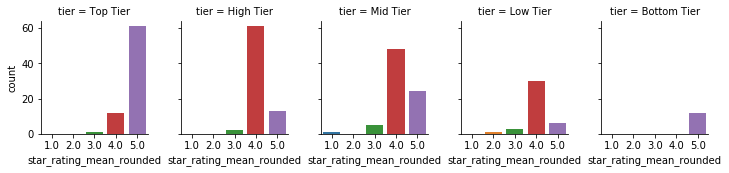

In [25]:
# distribution of stars ratings in reviews
# plt.hist(tier_training_dataset)
# plt.xlabel('Star Rating')
# plt.ylabel('Counts')

# sns.catplot(x="who", y="survived", col="class",
#                  data=titanic, saturation=.5,
#                  kind="bar", ci=None, aspect=.6)

tier_training_dataset['star_rating_mean_rounded'] = tier_training_dataset['star_rating_mean'].round()

g = sns.catplot("star_rating_mean_rounded", col="tier",
                 data=tier_training_dataset,
                 kind="count", height=2.5, aspect=.8)

plt.show()

In [26]:
# select feature and target columns
training_features = ['customer_id_count', 'star_rating_mean', 'helpful_votes_mean', 'total_votes_mean']
training_target = ['target']

# scale input variables
scaler = StandardScaler()
scaler.fit(tier_training_dataset[training_features])
X = scaler.transform(tier_training_dataset[training_features])
y = tier_training_dataset[training_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a model to learn from the dataset
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used)

# print best features
print("\ntop features:")
for coef in reversed(sorted(lasso.coef_)):
    if coef > 0:
        coef_index = list(lasso.coef_).index(coef)
        print("{} ({})".format(training_features[coef_index], coef))

training score: 0.29449968133734605
test score:  0.0693442022959132
number of features used:  4

top features:
customer_id_count (0.4217993051128214)
helpful_votes_mean (0.29451249808999075)
total_votes_mean (0.15805425941406773)
star_rating_mean (0.15695316399078257)


In [27]:
# Sample Predictions
predicted_values = np.clip(lasso.predict(X_test), 1., 5.)
predictions = np.array(list(zip(predicted_values, y_test.as_matrix().reshape(-1,))))
predictions[:10]

/Users/bear-mbp/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


array([[4.34054755, 5.        ],
       [3.05824005, 4.        ],
       [3.27875741, 2.        ],
       [3.41455071, 2.        ],
       [3.26450872, 3.        ],
       [5.        , 5.        ],
       [4.73099329, 4.        ],
       [2.84604114, 3.        ],
       [3.09642754, 4.        ],
       [3.05770743, 3.        ]])

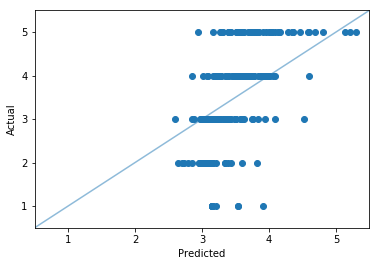

In [28]:
pred_train = lasso.predict(X_train)
plt.scatter(pred_train, y_train)
plt.plot([.5,5.5], [.5, 5.5], alpha=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim([.5, 5.5])
plt.ylim([.5, 5.5])
plt.show()

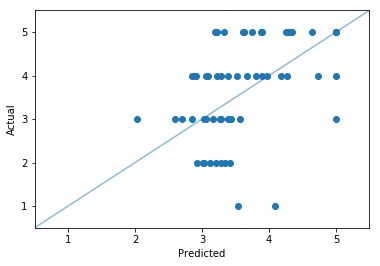

In [29]:
plt.scatter(predictions[:,0], predictions[:,1])
plt.plot([.5,5.5], [.5, 5.5], alpha=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xlim([.5, 5.5])
plt.ylim([.5, 5.5])
plt.show()

In [30]:
regression_metrics = explained_variance_score, mean_absolute_error, r2_score

for metric in regression_metrics:
    print(metric)
    pred_train = lasso.predict(X_train)
    print(metric(y_train, pred_train))

    pred_test = lasso.predict(X_test)
    print(metric(y_test, pred_test))

<function explained_variance_score at 0x12b2e2510>
0.29449968133734605
0.07036667718294698
<function mean_absolute_error at 0x12b2e22f0>
0.7548490306901855
0.8769099890953074
<function r2_score at 0x12b2e2598>
0.29449968133734605
0.0693442022959132


In [31]:
tier_training_dataset.to_csv("~/amzn_search_watches_train.csv", index=False)